LSTM and tensorflow

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 2.3254 - mae: 0.3795 - val_loss: 2.6685 - val_mae: 0.7336 - learning_rate: 5.0000e-05
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.2850 - mae: 0.3533 - val_loss: 2.5868 - val_mae: 0.6892 - learning_rate: 5.0000e-05
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.2502 - mae: 0.3367 - val_loss: 2.5079 - val_mae: 0.6438 - learning_rate: 5.0000e-05
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.2144 - mae: 0.3124 - val_loss: 2.4339 - val_mae: 0.5989 - learning_rate: 5.0000e-05
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.1661 - mae: 0.2713 - val_loss: 2.3600 - val_mae: 0.5498 - learning_rate: 5.0000e-05
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.1402 - mae: 0.2582 - val_loss: 2.2764 - val_mae: 0.4857 - learning_rate: 5.0000e-05
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.1027 - mae: 0.2256 - val_loss: 2.1907 - val_mae: 0.4089 - lea

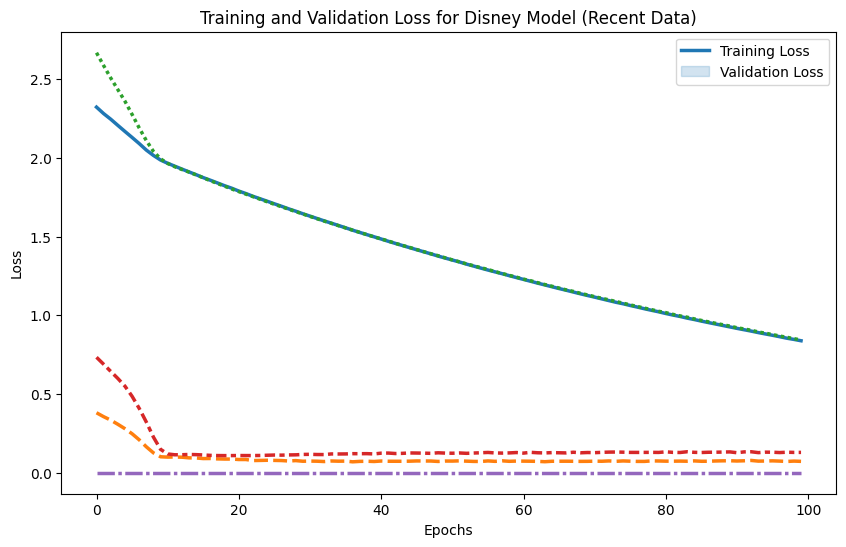

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2


training_file_path = 'datasets/training_disney.csv'
testing_file_path = 'datasets/testing_disney.csv'

training_data = pd.read_csv(training_file_path)
testing_data = pd.read_csv(testing_file_path)

# keeping the column names in lower case
training_data.columns = training_data.columns.str.lower()
testing_data.columns = testing_data.columns.str.lower()

# converting the date to datetime format
training_data['date'] = pd.to_datetime(training_data['date'], errors='coerce')
testing_data['date'] = pd.to_datetime(testing_data['date'], errors='coerce')

# sorting the training data by date
training_data = training_data.sort_values(by='date')

#selecting most recent training data, thanks to that the trends are more detectable
recent_training_data = training_data[training_data['date'] >= pd.to_datetime('2018-01-01')]

#  preparing the closing price values to be a target variable
recent_train_close_values = recent_training_data['close'].values.reshape(-1, 1)

# using MinMaxScaler to normalize the data to bring values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
recent_train_scaled = scaler.fit_transform(recent_train_close_values)

# function that creates sequences of data for LSTM input
def create_sequences(data, time_steps):
    X, y = [], []
     #making sequences of length time_steps to predict the next value
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps]) # past time_steps
        y.append(data[i + time_steps]) # next value after the sqeuence
    return np.array(X), np.array(y)

# the nuber of past days to make a prediction
time_steps = 90  
# sequences from recent training data
X_train_recent, y_train_recent = create_sequences(recent_train_scaled, time_steps)

# building LSTM model
model = Sequential()
# input layer with shape based on the time_steps and number of features
model.add(Input(shape=(time_steps, 1)))  
# first layer with 50 units that returns a sequence for the next layer
model.add(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)))
# reducing overfitting
model.add(Dropout(0.6))  
model.add(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))
model.add(LSTM(50, kernel_regularizer=l2(0.01)))
#relu activation for non-linearity
model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
# output layer with a single unit to predict next price
model.add(Dense(1))

#reduced learining rate for better training
optimizer = Adam(learning_rate=0.00005)  
#compiling the model with mean squared error and mean absolute error
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# early stopping if validation loss doesn't improve, saving the best model based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
model_checkpoint = ModelCheckpoint(filepath='best_disney_model_lstm.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# training the model 
history = model.fit(X_train_recent, y_train_recent, 
                    epochs=100, 
                    batch_size=32,  
                    verbose=1, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, model_checkpoint, lr_scheduler])

# plotting training and validation loss
plt.figure(figsize=(10, 6))
sns.lineplot(data=history.history, palette='tab10', linewidth=2.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Disney Model (Recent Data)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


This code trains an LSTM (Long Short-Term Memory) model.
I used LSTM since I read that is perfect for time series that because it captures dependencies and trends over time.
Firstly I prepared the data to include only recent data to focus on most relevant trends. I used MinMaxScaler to normalize the stock prices. I also created a function that creates time steps of 90 days to help the model learn patterns in stock price movements.

The model uses thre LSTM layers each with 50 units, dropout layers are added to prevent overfitting and the final layer includes a dense layer with ReLu activation for non-linearity and output layer to predict next stock price. I used Adam optimizer with low learning rate to improve convergence. I used EarlyStopping if validation performance stops improving to mainly save time. ModelChecpoint saves the model. ReduceLROnPlateau lowers the learning rate if validation loss plateaus.

Conclusion from the chart:
The training and validation loss decrease consistently, which shows that the model is learning good without overfitting. 



36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


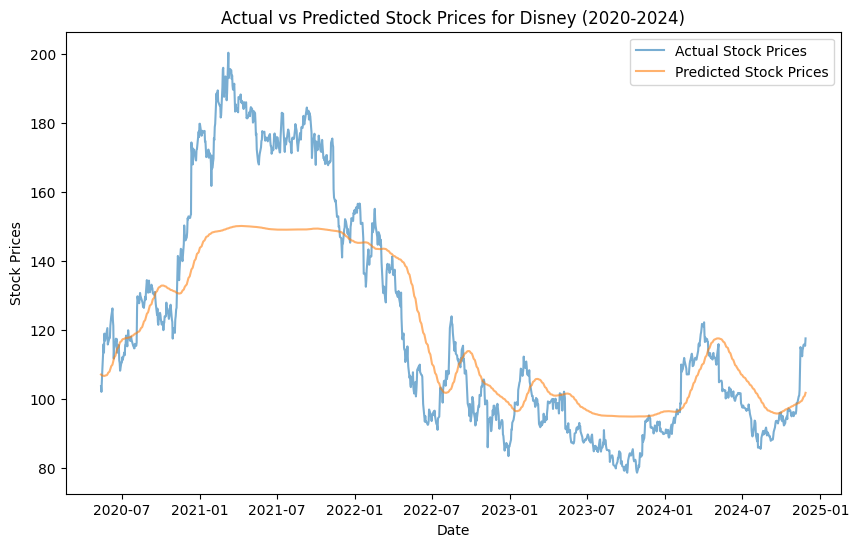

Disney Model - Mean Squared Error: 264.9554408296943
Disney Model - Mean Absolute Error: 12.6264279150838
Disney Model - Root Mean Squared Error: 16.277451914525635
Disney Model - R2 Score: 0.7621152390339392


In [4]:
# preparing data for predicitions
disney_test_close_values = testing_data['close'].values.reshape(-1, 1)

# scaling the future data as it was in the training
disney_test_scaled = scaler.transform(disney_test_close_values)

# sequences for future predictions
def create_future_sequences(data, time_steps):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
    return np.array(X)

# matching what was used duting training
time_steps = 90  
X_test_disney = create_future_sequences(disney_test_scaled, time_steps)

# predicting stock prices
y_pred_disney = model.predict(X_test_disney)

# transforming the predictions and values to original
predicted_disney = scaler.inverse_transform(y_pred_disney).flatten()
actual_disney = disney_test_close_values[time_steps:].flatten()

# plotting actual vs predicted
plt.figure(figsize=(10, 6))
sns.lineplot(
    x=testing_data['date'].iloc[time_steps:], 
    y=actual_disney, 
    label='Actual Stock Prices', alpha=0.6
)
sns.lineplot(
    x=testing_data['date'].iloc[time_steps:], 
    y=predicted_disney, 
    label='Predicted Stock Prices', alpha=0.6
)
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.title('Actual vs Predicted Stock Prices for Disney (2020-2024)')
plt.legend()
plt.show()

# metrics calculation
mse_disney = mean_squared_error(actual_disney, predicted_disney)
mae_disney = mean_absolute_error(actual_disney, predicted_disney)
rmse_disney = np.sqrt(mse_disney)
r2_disney = r2_score(actual_disney, predicted_disney)


print(f"Disney Model - Mean Squared Error: {mse_disney}")
print(f"Disney Model - Mean Absolute Error: {mae_disney}")
print(f"Disney Model - Root Mean Squared Error: {rmse_disney}")
print(f"Disney Model - R2 Score: {r2_disney}")


To predict I prepared the data from the testing dataset to match it with the training one.
Then I had to convert the predictions to theri original scale.

# Conclusions
The model performs well, R² score tells us that 76% of the variance in the prices is explained. The MAE and RMSE show that the model performs good showing good predictions, when it is still keeps good balance between accuracy and generalization.